In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error


### Loading Data

In [85]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv',index_col='date') 
df.drop(columns=['Unnamed: 0','state','cases_new_capita'], inplace=True)
df = df.groupby('date').sum()
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')
date_index = df.index


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1548 entries, 2020-01-25 to 2024-04-20
Freq: D
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cases_new                  1548 non-null   int64  
 1   cases_recovered            1548 non-null   int64  
 2   cases_active               1548 non-null   int64  
 3   cases_unvax                1548 non-null   int64  
 4   cases_pvax                 1548 non-null   int64  
 5   cases_fvax                 1548 non-null   int64  
 6   cases_0_4                  1548 non-null   int64  
 7   cases_5_11                 1548 non-null   int64  
 8   cases_12_17                1548 non-null   int64  
 9   cases_18_29                1548 non-null   int64  
 10  cases_30_39                1548 non-null   int64  
 11  cases_40_49                1548 non-null   int64  
 12  cases_50_59                1548 non-null   int64  
 13  cases_60_69           

In [86]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

Training data shape: (774, 25)
Testing data shape: (774, 25)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

---

In [6]:
def evaluate(test_data,pred):
    print(f'MSE : {mean_squared_error(test_data.cases_new,pred)}')
    print(f'RMSE : {root_mean_squared_error(test_data.cases_new,pred)}')
    print(f'R2 : {r2_score(test_data.cases_new,pred)}')
    print(f'MAE : {mean_absolute_error(test_data.cases_new,pred)}')

---

### Seasonal Decompose

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df['cases_new'], period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases_new'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}' )
print(f'Critical Values: {result[4]}')

ADF Statistic: -4.176908825015194
p-value: 0.0007207787314412768
Critical Values: {'1%': -3.4346453058155175, '5%': -2.8634371105641443, '10%': -2.5677799947325988}


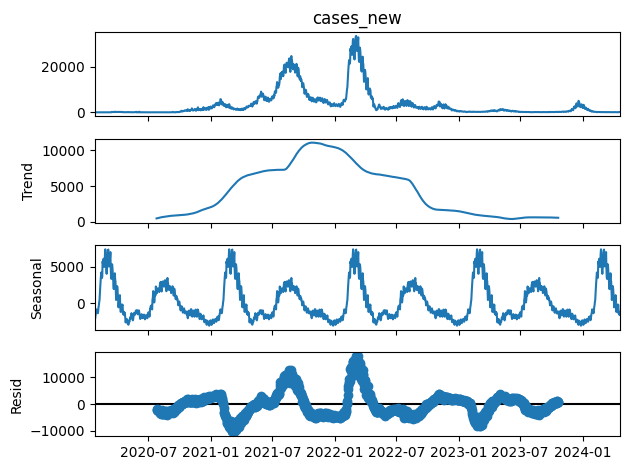

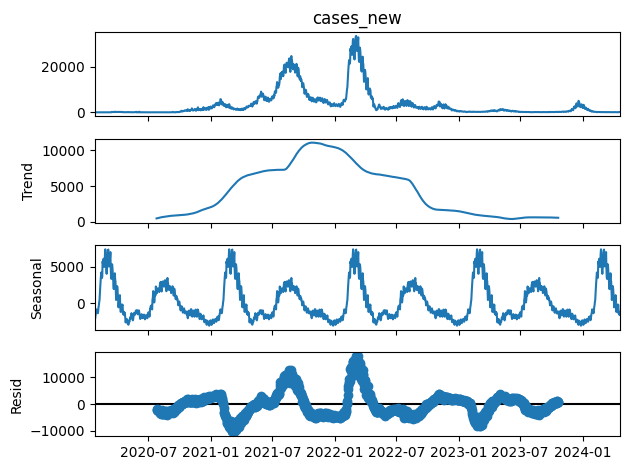

In [55]:
result.plot()

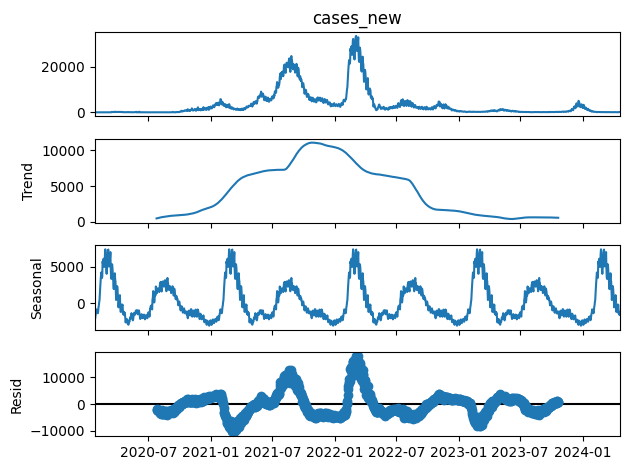

In [148]:
data_diff = df.diff()
data_diff = df.dropna()

dec = seasonal_decompose(data_diff['cases_new'],period = 365).plot()
plt.show()

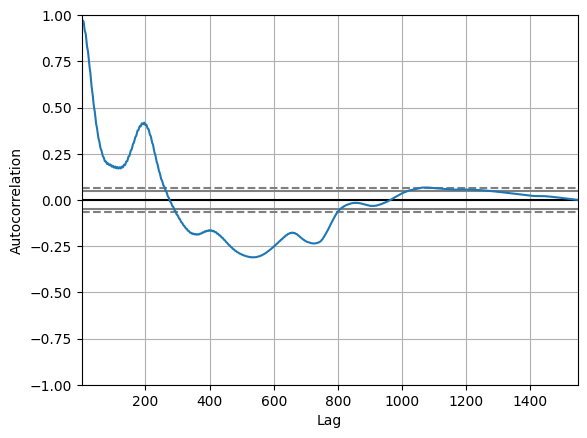

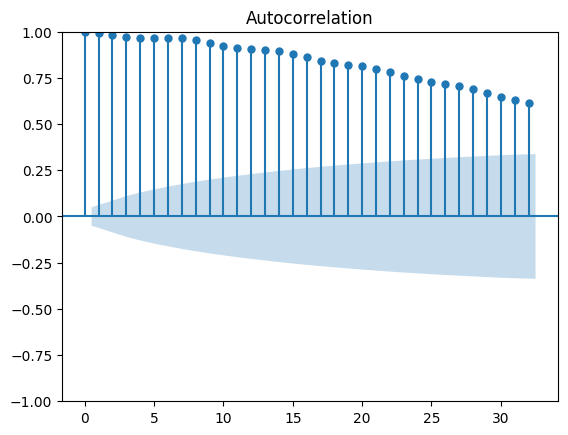

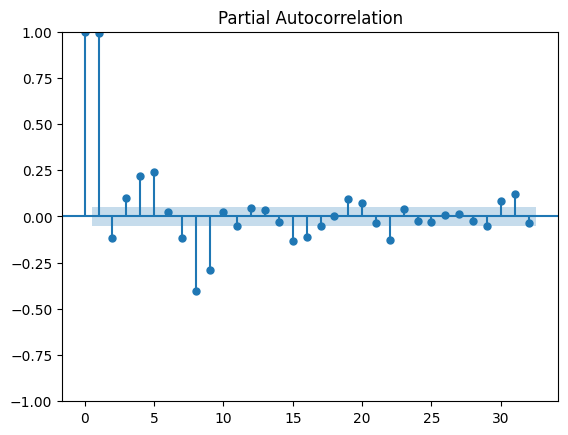

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['cases_new'])
plot_acf(df['cases_new'])
plot_pacf(df['cases_new'])
plt.show()

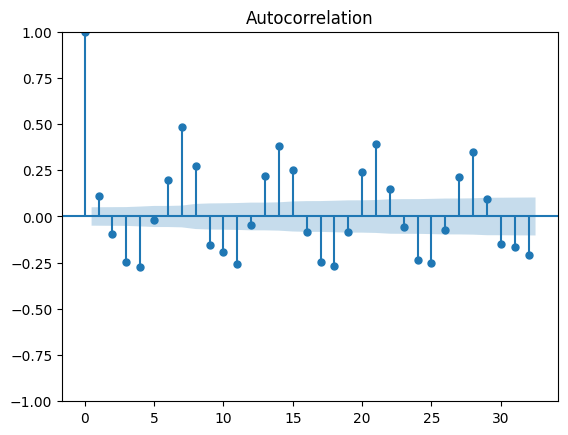

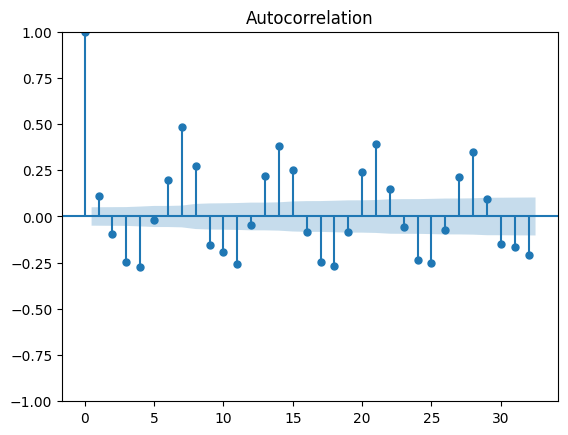

In [150]:
plot_acf(df['cases_new'].diff().dropna())

p parameter : 2nd Lag is the first lag to be  out of from the limit

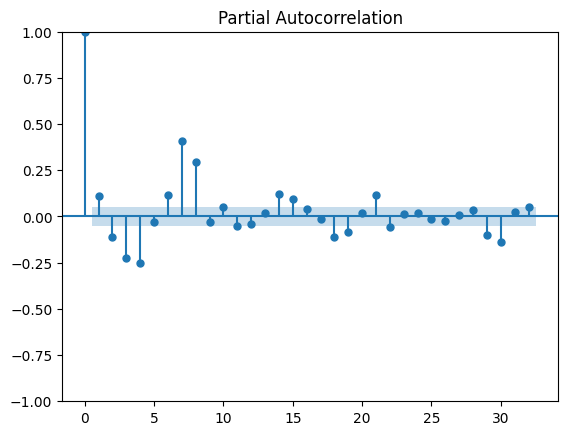

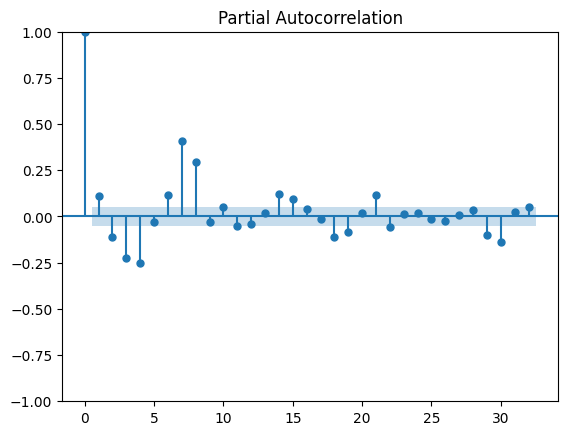

In [6]:
plot_pacf(df['cases_new'].diff().dropna())

q parameter : 2nd Lag is the limit before the first significant drop to or below zero

### ARIMA

In [57]:
import pmdarima as pm

model = pm.auto_arima(train_data['cases_new'], 
                      m=7,                                   
                      stationary=True,
                      d=None,            
                      test='adf',
                      start_p=0, start_q=0,             
                      trace=True,  
                      )


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=13861.941, Time=12.51 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=15870.201, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=6.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14322.917, Time=6.42 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16173.428, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=15003.064, Time=4.87 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=6.00 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=28.82 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=14075.144, Time=17.14 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=14466.802, Time=8.52 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=27.99 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=30.74 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=12363.698, Time=17.76 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=12490.538, Time=9.15 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1

c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,0,1)(2,0,0)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\marcu\On

 ARIMA(1,0,1)(2,0,0)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(2,0,2)[7]             : AIC=inf, Time=30.33 sec
 ARIMA(0,0,1)(1,0,1)[7]             : AIC=13285.964, Time=12.19 sec
 ARIMA(1,0,0)(1,0,1)[7]             : AIC=12362.297, Time=14.05 sec
 ARIMA(2,0,1)(1,0,1)[7]             : AIC=12379.313, Time=14.33 sec
 ARIMA(1,0,2)(1,0,1)[7]             : AIC=12360.593, Time=17.30 sec
 ARIMA(0,0,0)(1,0,1)[7]             : AIC=13686.836, Time=7.45 sec
 ARIMA(0,0,2)(1,0,1)[7]             : AIC=inf, Time=20.18 sec
 ARIMA(2,0,0)(1,0,1)[7]             : AIC=12358.188, Time=9.78 sec
 ARIMA(2,0,2)(1,0,1)[7]             : AIC=12361.901, Time=16.50 sec

Best model:  ARIMA(1,0,1)(1,0,1)[7]          
Total fit time: 969.428 seconds


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  774
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6174.047
Date:                           Mon, 08 Jul 2024   AIC                          12358.093
Time:                                   16:43:09   BIC                          12381.351
Sample:                               01-25-2020   HQIC                         12367.042
                                    - 03-08-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9899      0.003    360.620      0.000       0.984       0.995
ma.L1         -0.0974      0.018     -5.423      0.000      -0.133      -0.062
ar.S.L7        0.9539      0.017     55.458      0.000       0.920       0.988
ma.S.L7       -0.6523      0.028    -22.902      0.000      -0.708      -0.596
sigma2      4.882e+05   9668.192     50.497      0.000    4.69e+05    5.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4669.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             518.08   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
future_dates_count = 1
forecast = model.predict(n_periods= 773 + future_dates_count )
forecast_index = test_data.index
forecast_dates = pd.date_range(start=test_data.index[0], periods=future_dates_count)
print(forecast)

2022-03-09    33388.650154
2022-03-10    34994.212727
2022-03-11    35183.091730
2022-03-12    34818.850425
2022-03-13    31952.121233
                  ...     
2024-04-16     1026.524528
2024-04-17     1029.624713
2024-04-18     1030.042579
2024-04-19     1022.643021
2024-04-20     1012.243117
Freq: D, Length: 774, dtype: float64


In [60]:
arima_forecast = pd.DataFrame({'forecast':forecast},index=forecast_dates)

In [13]:
len(forecast)

774

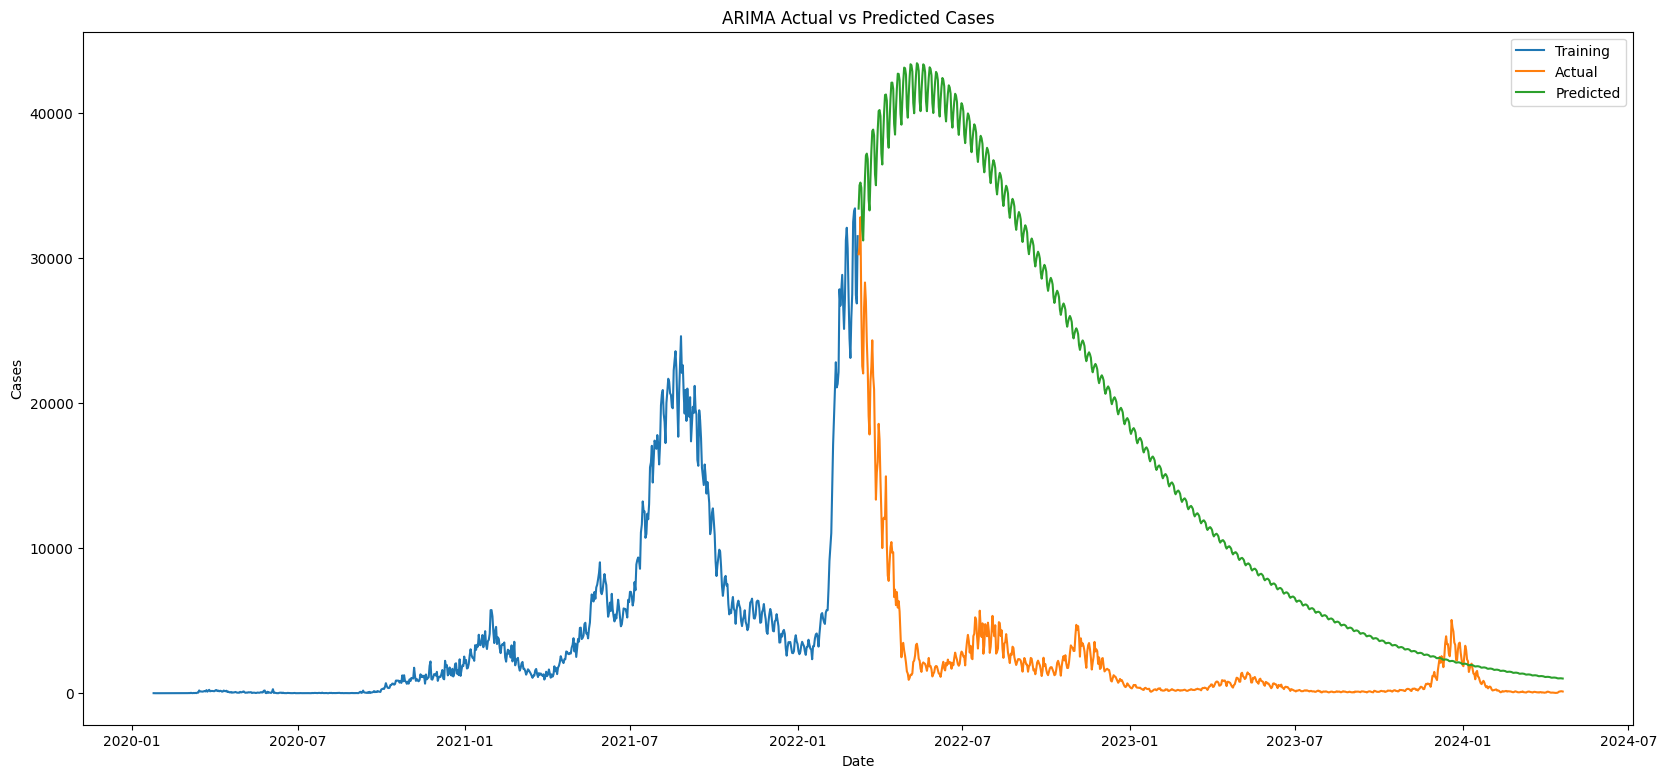

In [61]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('ARIMA Actual vs Predicted Cases')
plt.legend()
plt.show()

In [62]:
evaluate(test_data,forecast)

MSE : 379548414.0737204
RMSE : 19482.00231171633
R2 : -20.54807305555815
MAE : 14617.208957119281


In [19]:
evaluate(test_data,forecast)

MSE : 379529815.4036303
RMSE : 19481.524976336692
R2 : -20.547017154684962
MAE : 14616.731446633346


In [63]:
'''import pickle
with open("ARIMA_model.pkl", "wb") as file:
    pickle.dump(model, file)'''

----

### Prophet

In [23]:
from prophet import Prophet

In [64]:
# Modifying df to fit prophet model
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

#Training Data
trainprophet = train_data
trainprophet['ds'] = train_data.index
trainprophet.rename(columns={'cases_new':'y'},inplace=True)


#Testing Data
testprophet = test_data
testprophet['ds'] = test_data.index
testprophet = testprophet.reset_index(drop=True)

'''future_dates_count = 365//4
forecast_dates = pd.date_range(start=test_data.index[-1], periods=future_dates_count)
testprop_df =pd.DataFrame({'ds':forecast_dates})'''


Training data shape: (774, 25)
Testing data shape: (774, 25)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

C:\Users\marcu\AppData\Local\Temp\ipykernel_23560\3767377218.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprophet['ds'] = train_data.index
C:\Users\marcu\AppData\Local\Temp\ipykernel_23560\3767377218.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprophet.rename(columns={'cases_new':'y'},inplace=True)
C:\Users\marcu\AppData\Local\Temp\ipykernel_23560\3767377218.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

"future_dates_count = 365//4\nforecast_dates = pd.date_range(start=test_data.index[-1], periods=future_dates_count)\ntestprop_df =pd.DataFrame({'ds':forecast_dates})"

In [65]:
trainprophet

,y,cases_recovered,cases_active,cases_unvax,cases_pvax,cases_fvax,cases_0_4,cases_5_11,cases_12_17,cases_18_29,...,daily_partial,daily,admitted_covid_hospital,admitted_total_hospital,discharged_covid_hospital,discharged_total_hospital,hosp_covid_hospital,icu_covid,vent_covid,ds
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,4,0,4,4,0,0,0,0,0,0,...,0.0,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,2020-01-25
2020-01-26,0,0,4,0,0,0,0,0,0,0,...,0.0,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,2020-01-26
2020-01-27,0,0,4,0,0,0,0,0,0,0,...,0.0,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,2020-01-27
2020-01-28,0,0,4,0,0,0,0,0,0,0,...,0.0,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,2020-01-28
2020-01-29,3,0,7,3,0,0,1,0,0,0,...,0.0,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,2020-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,33209,26352,305017,5164,617,10958,1880,2285,1517,8977,...,23720.0,84379.0,1994.0,2626.0,1517.0,1932.0,7130.0,348.0,211.0,2022-03-04
2022-03-05,33406,27143,311213,4899,617,10847,1800,2211,1508,9184,...,30992.0,70817.0,2020.0,2574.0,1523.0,1959.0,7391.0,372.0,226.0,2022-03-05
2022-03-06,27435,30335,308258,4055,516,8670,1573,1757,1110,7310,...,25007.0,58853.0,1742.0,2213.0,1346.0,1727.0,7416.0,380.0,216.0,2022-03-06


In [66]:
m = Prophet(growth='logistic')
trainprophet['cap'] = df['cases_new'].max() 
trainprophet['floor'] = 0
m.fit(trainprophet)

C:\Users\marcu\AppData\Local\Temp\ipykernel_23560\1464507281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprophet['cap'] = df['cases_new'].max()
C:\Users\marcu\AppData\Local\Temp\ipykernel_23560\1464507281.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprophet['floor'] = 0
13:49:31 - cmdstanpy - INFO - Chain [1] start processing
13:49:32 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
testprophet['cap'] = df['cases_new'].max()
testprophet['floor'] = 0
forecastProphet = m.predict(testprophet)

In [68]:
forecastProphet.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-09,16733.331945,33406,0,13485.135063,23655.094125,16733.331945,16733.331945,1651.619018,1651.619018,...,74.583376,74.583376,74.583376,1577.035642,1577.035642,1577.035642,0.0,0.0,0.0,18384.950963
1,2022-03-10,16782.503449,33406,0,13029.478758,23274.886717,16782.503434,16782.503434,1556.683931,1556.683931,...,295.766368,295.766368,295.766368,1260.917563,1260.917563,1260.917563,0.0,0.0,0.0,18339.187380
2,2022-03-11,16831.673575,33406,0,13327.913534,23242.325287,16831.673507,16831.673507,1257.709962,1257.709962,...,309.358919,309.358919,309.358919,948.351043,948.351043,948.351043,0.0,0.0,0.0,18089.383537
3,2022-03-12,16880.841471,33406,0,12408.151460,22787.977454,16880.841322,16880.841322,834.536811,834.536811,...,191.452725,191.452725,191.452725,643.084086,643.084086,643.084086,0.0,0.0,0.0,17715.378283
4,2022-03-13,16930.006285,33406,0,11932.668627,22395.467399,16930.006057,16930.006057,136.645737,136.645737,...,-211.960620,-211.960620,-211.960620,348.606356,348.606356,348.606356,0.0,0.0,0.0,17066.652022


In [69]:
forecastProphet = forecastProphet[['ds','yhat','yhat_upper','yhat_lower']]
forecastProphet = forecastProphet.set_index('ds')
forecastProphet 

,yhat,yhat_upper,yhat_lower
ds,,,
2022-03-09,18384.950963,23655.094125,13485.135063
2022-03-10,18339.187380,23274.886717,13029.478758
2022-03-11,18089.383537,23242.325287,13327.913534
2022-03-12,17715.378283,22787.977454,12408.151460
2022-03-13,17066.652022,22395.467399,11932.668627
...,...,...,...
2024-04-16,32142.977745,37069.406714,27258.477788
2024-04-17,32324.964025,37517.686742,27466.842735
2024-04-18,32531.829048,37407.301342,27292.075797


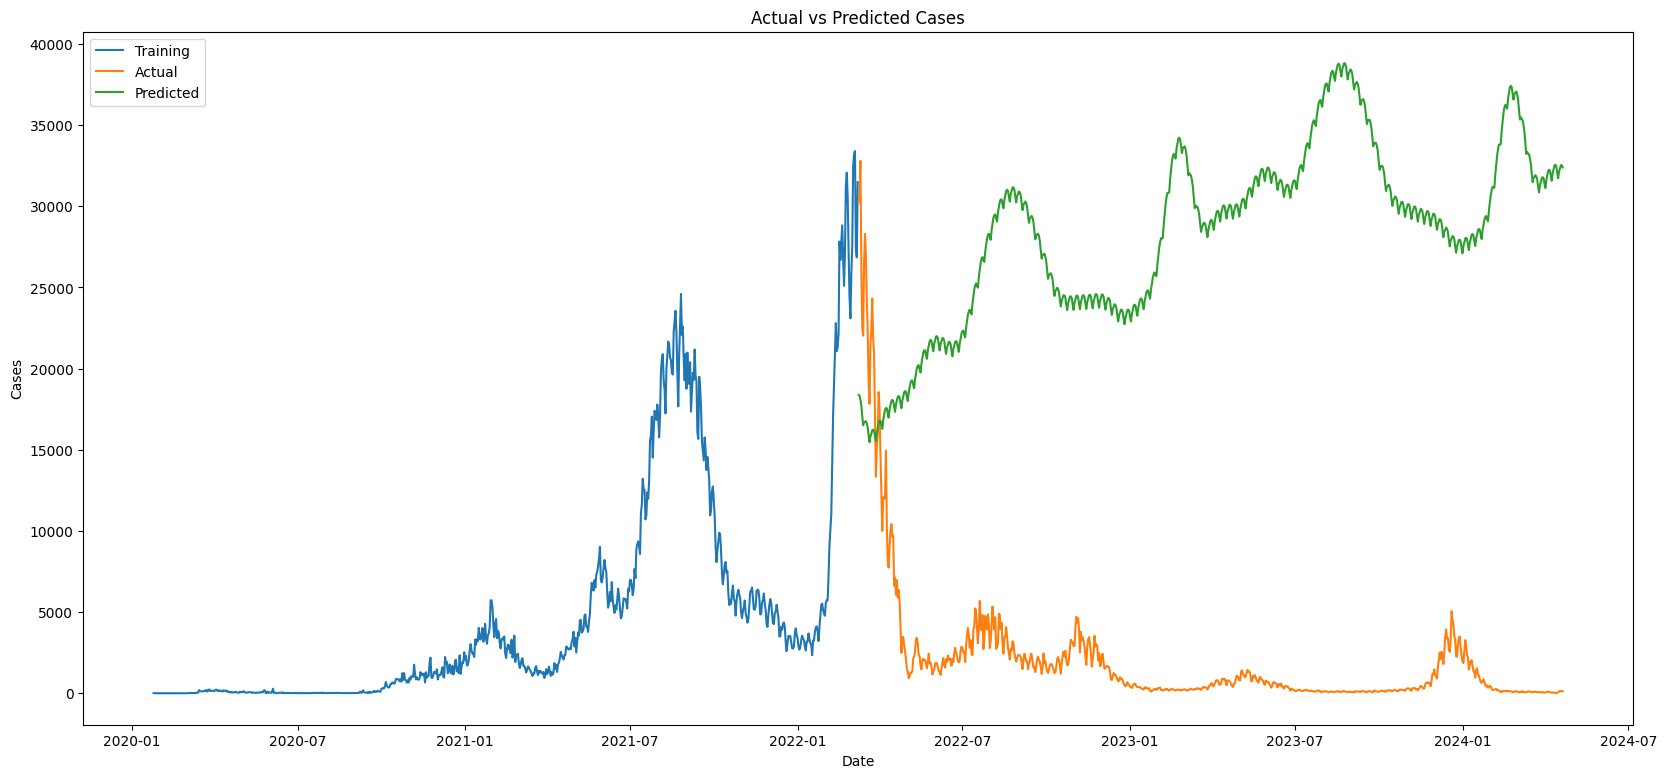

In [70]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y=train_data['y'], label='Training')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['cases_new'], label='Actual')
sns.lineplot(data=forecastProphet['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.show()

In [165]:
evaluate(test_data,forecastProphet['yhat'])

MSE : 764633100.6512817
RMSE : 27651.999939448895
R2 : -42.41045648614285
MAE : 26664.361894891474


In [71]:
"""
with open("prophet_model.pkl", "wb") as file:
    pickle.dump(model, file)"""

----

### LSTM

In [87]:
from sklearn.preprocessing import MinMaxScaler
#Scale between 0-1 as LSTM is very sensitive to varying data
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

In [88]:
train_data = df_scaled[:split_index]
test_data = df_scaled[split_index:]

In [89]:
print(len(train_data))
print(len(test_data))

774
774


In [90]:
trainX = []
trainY = []

future = 1 # Number of steps ahead to predict
past = 14 #Past steps used for 1 predictions

for i in range(past,len(train_data)-future+1):
    trainX.append(train_data[i-past:i,0:df.shape[1]])  # TS sequence, all columns/features from 0 to num_features
    trainY.append(train_data[i+future-1:i+future,0]) # TS sequence, all columns/features from 0 to num_features
    

In [91]:
testX = []
testY = []

for i in range(past, len(test_data) - future + 1):
    testX.append(test_data[i-past:i, 0:df.shape[1]]) # TS sequence, all columns/features from 0 to num_features
    testY.append(test_data[i+future-1:i+future, 0])  # TS sequence, all columns/features from 0 to num_features
  

In [92]:
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

In [93]:
print(trainX.shape) #(samples,past,features)
print(trainY.shape) #(samples,pred)
print(testX.shape) 
print(testY.shape)


(760, 14, 25)
(760, 1)
(760, 14, 25)
(760, 1)


In [94]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [125]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 14, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,489 (388.63 KB)

 Trainable params: 99,489 (388.63 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
history = model.fit(trainX,trainY,epochs=20,batch_size=16, validation_data=(testX, testY),verbose=1)

Epoch 1/20


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0286 - val_loss: 0.0015
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0085 - val_loss: 5.7780e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0079 - val_loss: 6.3196e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0086 - val_loss: 6.2553e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0066 - val_loss: 7.6725e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0053 - val_loss: 9.1405e-04
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0039 - val_loss: 9.5793e-04
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/st

In [117]:
future_dates_count = len(test_data)-14
forecast_dates = pd.date_range(start='2022-03-23', periods=future_dates_count)
forecast = model.predict(testX[-future_dates_count:])

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [127]:
forecast

array([[0.6336608 ],
       [0.6331495 ],
       [0.64464796],
       [0.64787996],
       [0.6459793 ],
       [0.6238886 ],
       [0.58733225],
       [0.5619576 ],
       [0.54450893],
       [0.5427551 ],
       [0.54229295],
       [0.53170675],
       [0.51113534],
       [0.4827529 ],
       [0.46430486],
       [0.45237127],
       [0.44612193],
       [0.45293427],
       [0.44606683],
       [0.42930427],
       [0.41121405],
       [0.39955243],
       [0.3966158 ],
       [0.39975992],
       [0.4038963 ],
       [0.40828827],
       [0.39908573],
       [0.38891652],
       [0.3761336 ],
       [0.36788675],
       [0.35687152],
       [0.3477947 ],
       [0.33802179],
       [0.32121852],
       [0.2967317 ],
       [0.27375597],
       [0.25360397],
       [0.23282668],
       [0.2117295 ],
       [0.18985882],
       [0.16828248],
       [0.14723654],
       [0.12595883],
       [0.10540435],
       [0.08859226],
       [0.0737279 ],
       [0.06205619],
       [0.054

In [128]:
forecast_copies = np.repeat(forecast,df.shape[1],axis=-1)
pred = scaler.inverse_transform(forecast_copies)[:,0]

In [129]:
lstm_result = pd.DataFrame({'forecast':pred},index=forecast_dates)

In [130]:
lstm_result

,forecast
2022-03-23,21168.072266
2022-03-24,21150.992188
2022-03-25,21535.109375
2022-03-26,21643.078125
2022-03-27,21579.583984
...,...
2024-04-16,317.062958
2024-04-17,320.052795
2024-04-18,323.818695
2024-04-19,327.763275


In [131]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

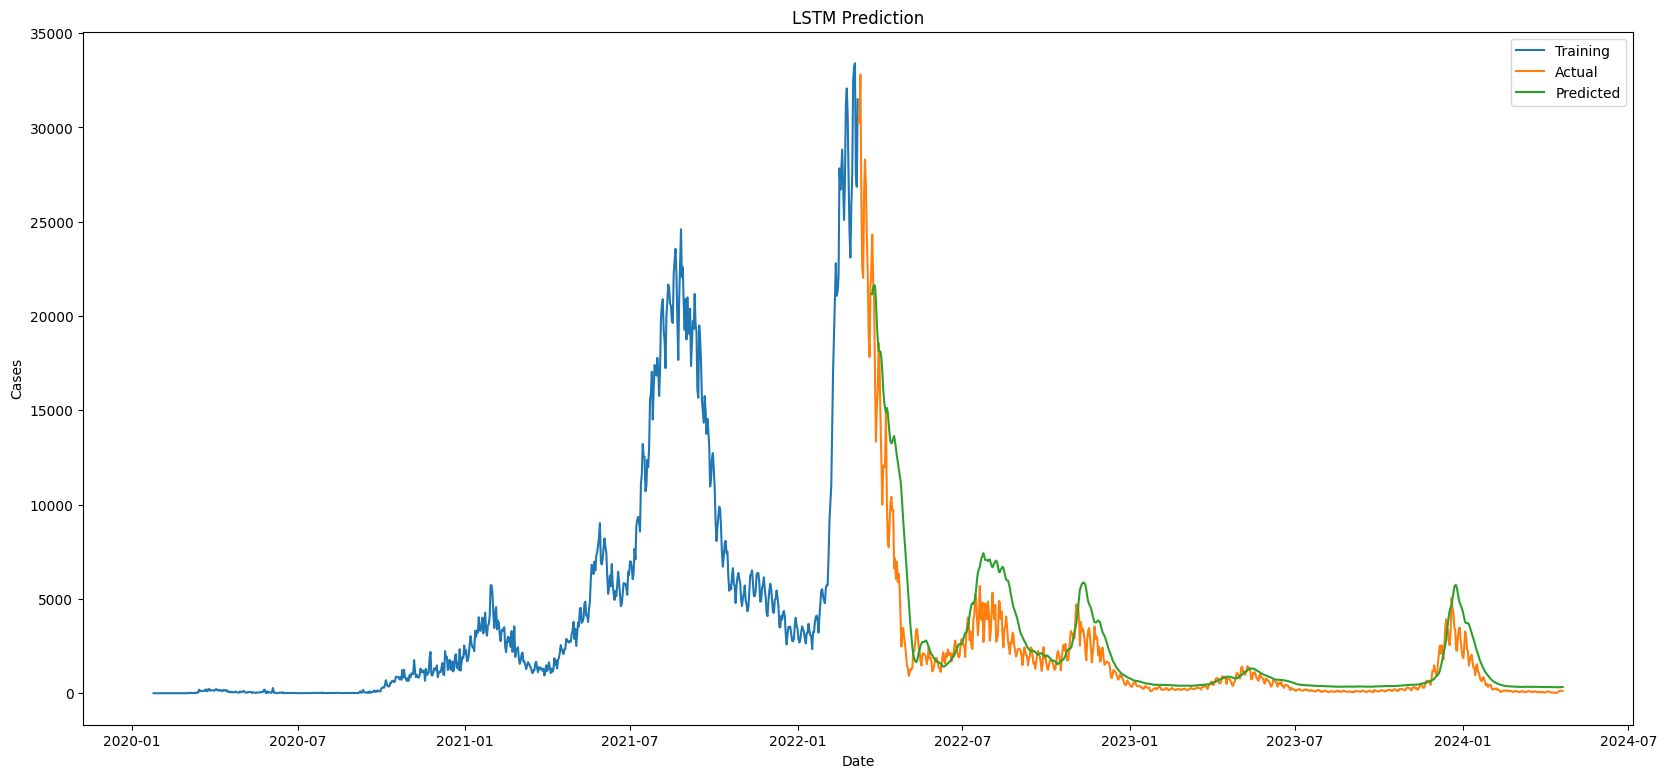

In [133]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=lstm_result,x=lstm_result.index,y='forecast', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

In [134]:
evaluate(test_data[14:],lstm_result['forecast'])

MSE : 2314334.309204743
RMSE : 1521.2936301729337
R2 : 0.696894645690918
MAE : 822.3553971541555


---

### Univariate LSTM

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df[['cases_new']])
df_scaled_uni = scaler.transform(df[['cases_new']])

In [136]:
train_data = df_scaled_uni[:split_index]
test_data = df_scaled_uni[split_index:]

In [137]:
trainX = []
trainY = []

future = 1 # Number of steps ahead to predict
past = 14 #Past steps used for 1 predictions

for i in range(past,len(train_data)-future+1):
    trainX.append(train_data[i-past:i,0:df.shape[1]])  # TS sequence, all columns/features from 0 to num_features
    trainY.append(train_data[i+future-1:i+future,0]) # TS sequence, all columns/features from 0 to num_features
    

In [138]:
testX = []
testY = []

for i in range(past, len(test_data) - future + 1):
    testX.append(test_data[i-past:i, 0:df.shape[1]]) # TS sequence, all columns/features from 0 to num_features
    testY.append(test_data[i+future-1:i+future, 0])  # TS sequence, all columns/features from 0 to num_features
  

In [139]:
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

In [140]:
print(trainX.shape) #(samples,past,features)
print(trainY.shape) #(samples,pred)
print(testX.shape) 
print(testY.shape)


(760, 14, 1)
(760, 1)
(760, 14, 1)
(760, 1)


In [151]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

c:\Users\marcu\OneDrive\Documents\repos\5011-cem-ml\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 14, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
history = model.fit(trainX,trainY,epochs=15,batch_size=16, validation_data=(testX, testY),verbose=1)

Epoch 1/15


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0322 - val_loss: 0.0016
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 6.3996e-04
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0030 - val_loss: 7.2708e-04
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 8.0013e-04
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 7.6762e-04
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 8.9803e-04
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 4.9512e-04
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 7.1654e-04
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 4.5615e-04
Epoch 11/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [153]:
future_dates_count = len(test_data)-14
forecast_dates = pd.date_range(start='2022-03-23', periods=future_dates_count)
forecast = model.predict(testX[-future_dates_count:]) 

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [154]:
pred = scaler.inverse_transform(forecast)[:,0]

In [155]:
lstm_result = pd.DataFrame({'forecast':pred},index=forecast_dates)

In [156]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

In [157]:
lstm_result

,forecast
2022-03-23,20332.615234
2022-03-24,20292.398438
2022-03-25,20426.873047
2022-03-26,20270.181641
2022-03-27,19952.345703
...,...
2024-04-16,500.063843
2024-04-17,500.948273
2024-04-18,505.788574
2024-04-19,513.298523


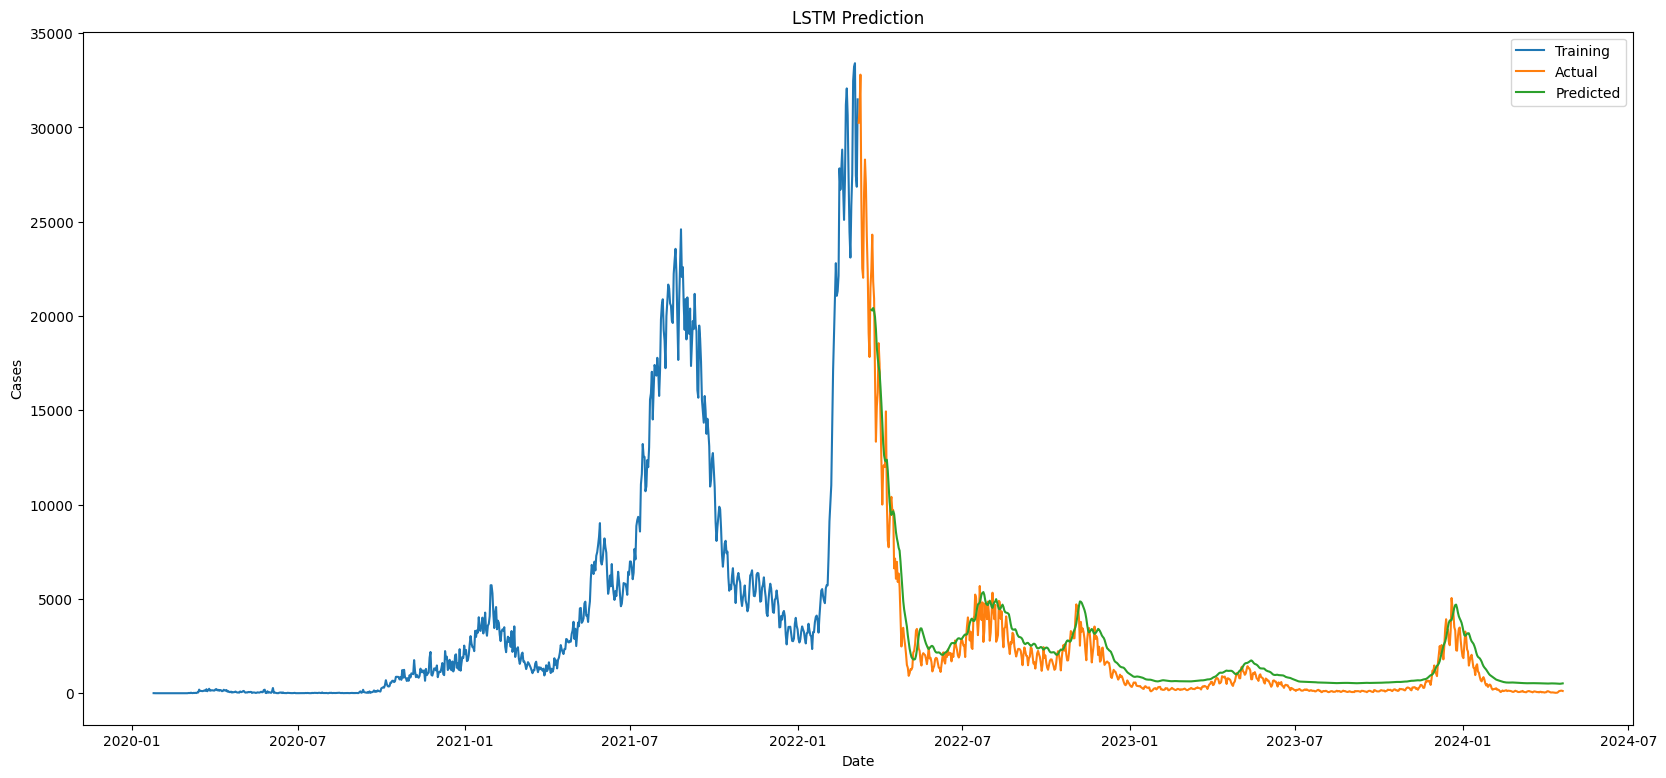

In [158]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=lstm_result,x=lstm_result.index,y='forecast', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

In [159]:
evaluate(test_data[14:],lstm_result['forecast'])

MSE : 752200.7209542913
RMSE : 867.2950599157655
R2 : 0.9014852643013
MAE : 655.4488382038318


---

### Exponential Smoothing

In [110]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [111]:
model = ExponentialSmoothing(train_data['cases_new'],seasonal='add',seasonal_periods=365)

In [112]:
fit = model.fit()
forecast = fit.forecast(len(test_data))

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [113]:
forecast

2022-03-09    31166.787077
2022-03-10    31278.871098
2022-03-11    31424.925459
2022-03-12    31296.335434
2022-03-13    31138.605297
                  ...     
2024-04-16    30862.214238
2024-04-17    30711.454764
2024-04-18    30582.060253
2024-04-19    30829.421628
2024-04-20    30817.298730
Freq: D, Length: 774, dtype: float64

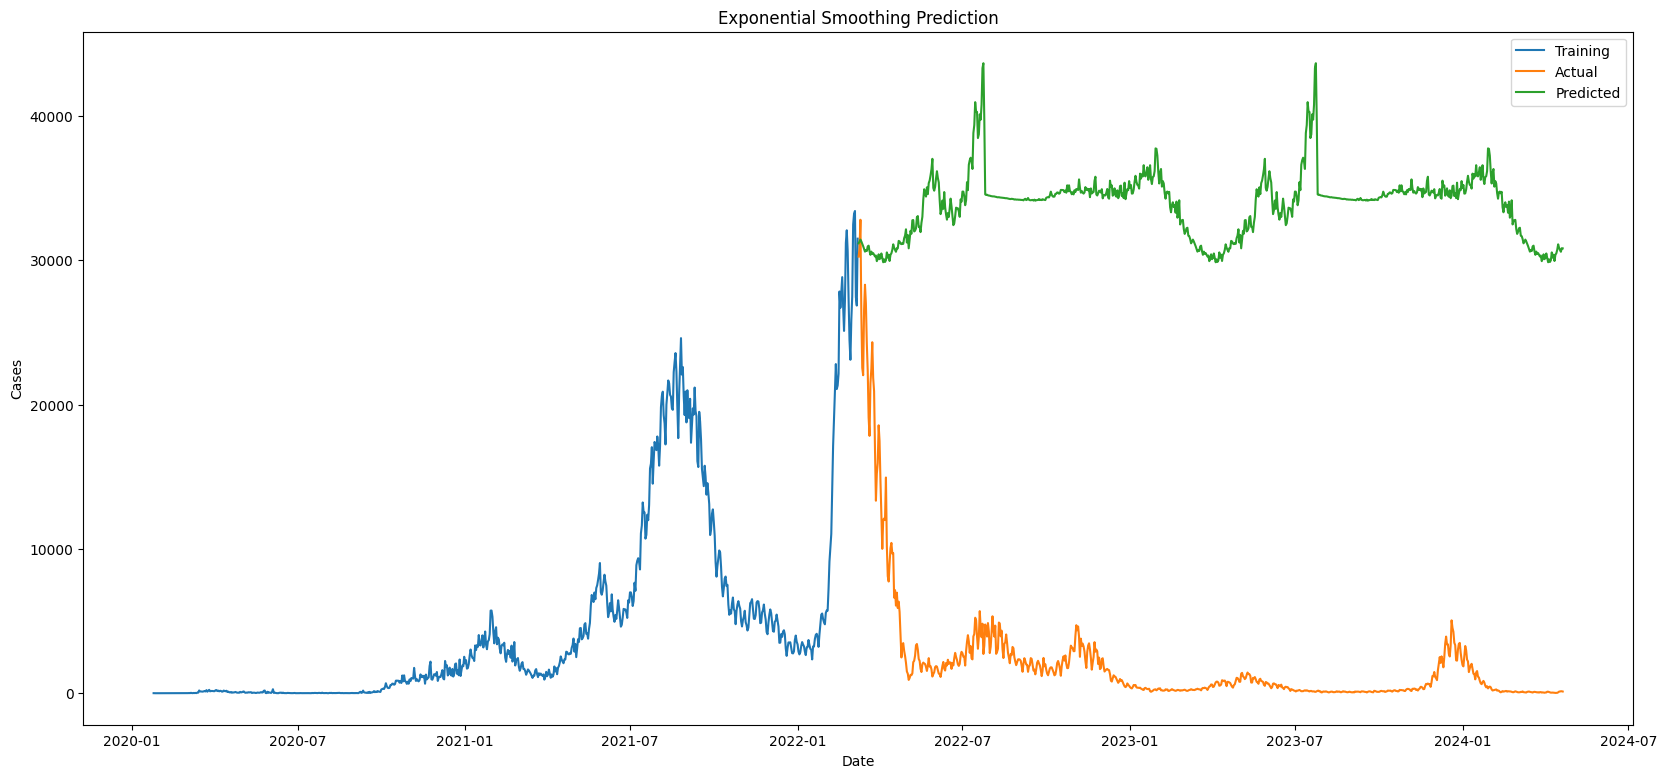

In [116]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Exponential Smoothing Prediction')
plt.legend()
plt.show()

In [117]:
evaluate(test_data,forecast)

MSE : 1039858131.2600107
RMSE : 32246.831336737734
R2 : -58.03578607880771
MAE : 31829.37459989971
